Best parameters: {'regression__alpha': 1}
Best cross-validation relative MSE score: 1.1955261493185026e-07
Relative Mean Squared Error: 1.1425867422290241e-08
Test Mean Squared Error: 0.8848122246973449


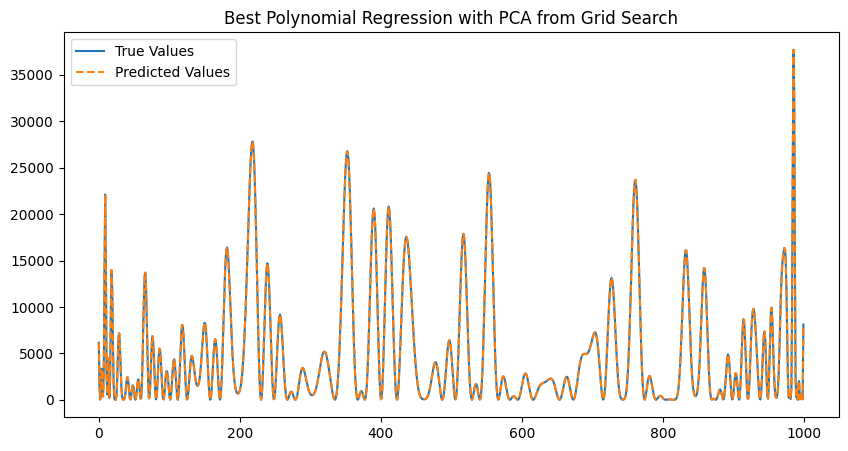

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline


def load_data(filename):
    """
    :param filename:
    :return: data, labels
    """
    data = np.load(filename)
    return data, np.square(data)


def mse_relative(y_true, y_pred):
    """
    :param y_true:
    :param y_pred:
    :return: average relative mse
    """
    # Handle y_true is zero
    non_zero_mask = y_true != 0
    return np.mean(np.square(np.linalg.norm(y_true[non_zero_mask] - y_pred[non_zero_mask], axis=-1) / np.linalg.norm(y_true[non_zero_mask], axis=-1)))


X, Y = load_data('toy_quadratic_data_iter_10000_order_100.npy')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Framework Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.9999)),
    ('poly_features', PolynomialFeatures(2)),
    ('regression', Ridge())
])

# Parameters for Grid Search
param_grid = {
    'regression__alpha': [1,2]
}

# Custom scorer for grid search
custom_scorer = make_scorer(mse_relative, greater_is_better=False)

# Grid search CV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation relative MSE score:", -grid_search.best_score_)

# Evaluate on test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
relative_mse = mse_relative(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print(f"Relative Mean Squared Error: {relative_mse}")
print(f"Test Mean Squared Error: {mse}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test[100], label='True Values')
plt.plot(predictions[100], label='Predicted Values', linestyle='--')
plt.legend()
plt.title("Best Polynomial Regression with PCA from Grid Search")
plt.show()